In [1]:
import sys, os
import time
from pathlib import Path
import motornet as mn
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import json
from task import CentreOutFF
from policy import Policy
from plotting import plot_simulations, plot_training_log, plot_activation
from utils import calculate_angles_between_vectors, create_directory
from tqdm import tqdm
device = th.device("cpu")

In [2]:
# Function to load (or make new) Environment

def load_env(task, cfg=None):

    if cfg is None:

        name = 'env'

        action_noise         = 1e-4
        proprioception_noise = 1e-3
        vision_noise         = 1e-4
        vision_delay         = 0.05
        proprioception_delay = 0.02

        # Define task and the effector
        effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle())

        max_ep_duration = 1.0
    else:
        name = cfg['name']
        # effector
        muscle_name = cfg['effector']['muscle']['name']
        timestep = cfg['effector']['dt']
        muscle = getattr(mn.muscle,muscle_name)()
        effector = mn.effector.RigidTendonArm26(muscle=muscle,timestep=timestep) 

        # delay
        proprioception_delay = cfg['proprioception_delay']*cfg['dt']
        vision_delay = cfg['vision_delay']*cfg['dt']

        # noise
        action_noise = cfg['action_noise'][0]
        proprioception_noise = cfg['proprioception_noise'][0]
        vision_noise = cfg['vision_noise'][0]

        # initialize environment
        max_ep_duration = cfg['max_ep_duration']


    env = task(effector=effector,max_ep_duration=max_ep_duration,name=name,
               action_noise=action_noise,proprioception_noise=proprioception_noise,
               vision_noise=vision_noise,proprioception_delay=proprioception_delay,
               vision_delay=vision_delay)

    return env

In [3]:
# Function to Train a Network

def train(model_num, ff_coefficient, phase, condition='train', directory_name=None, n_batch=None, batch_size=None, interval=100):

  output_folder = create_directory(directory_name=directory_name)
  model_name = "model{:02d}".format(model_num)
  device = th.device("cpu")

  # Set configuaration and network
  if phase>=1:
    print("Training phase {}...".format(phase))
    # load config and weights from the previous phase
    weight_file = list(Path(output_folder).glob(f'{model_name}_phase={phase-1}_*_weights'))[0]
    cfg_file = list(Path(output_folder).glob(f'{model_name}_phase={phase-1}_*_cfg.json'))[0]

    # load configuration
    with open(cfg_file,'r') as file:
      cfg = json.load(file)

    # environment and network
    env = load_env(CentreOutFF,cfg)
    policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device, freeze_output_layer=True)
    policy.load_state_dict(th.load(weight_file))

  else:
    # environment and network
    env = load_env(CentreOutFF)
    policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device)
  
  if condition=='growing_up': 
    optimizer = th.optim.Adam(policy.parameters(), lr=0.001,eps=1e-7)
    catch_trial_perc = 50

  else: # for training use biologily plausible optimizer
    optimizer = th.optim.SGD(policy.parameters(), lr=0.001)
    catch_trial_perc = 50

  # define an l1 loss function
  def l1(x, y):
    """L1 loss"""
    return th.mean(th.sum(th.abs(x - y), dim=-1))

  # Train network
  overall_losses = []
  input_losses = []
  position_losses = []
  angle_losses = []
  muscle_losses = []
  hidden_losses = []

  batch_time = 0.0
  forward_time = 0.0
  loss_time = 0.0
  backward_time = 0.0
  optimstep_time = 0.0

  for batch in tqdm(range(n_batch), desc=f"Training {phase}", unit="batch"):

    batch_start_time = time.time()

    # Run episode
    h = policy.init_hidden(batch_size = batch_size)

    obs, info = env.reset(condition        = 'train', 
                          catch_trial_perc = catch_trial_perc, 
                          ff_coefficient   = ff_coefficient, 
                          options          = {'batch_size':batch_size})
    terminated = False

    # initial positions and targets
    xy = []
    tg = []
    all_actions = []
    all_hidden = []
    all_muscle = []
    all_force = []

    # simulate whole episode
    while not terminated:  # will run until `max_ep_duration` is reached
      action, h = policy(obs,h)
      all_hidden.append(h[0,:,None,:])
      obs, _, terminated, _, info = env.step(action=action)
      xy.append(info['states']['cartesian'][:, None, :])  # trajectories
      tg.append(info["goal"][:, None, :])  # targets
      all_actions.append(action[:, None, :])
      all_muscle.append(info['states']['muscle'][:,0,None,:])
      all_force.append(info['states']['muscle'][:,6,None,:])

    # concatenate into a (batch_size, n_timesteps, xy) tensor
    xy = th.cat(xy, axis=1)
    tg = th.cat(tg, axis=1)
    
    all_actions = th.cat(all_actions, axis=1)
    all_muscle = th.cat(all_muscle, axis=1)
    all_hidden = th.cat(all_hidden, axis=1)
    all_force = th.cat(all_force, axis=1)

    forward_time += (time.time() - batch_start_time)
    loss_start_time = time.time()

    # CALCULATE LOSSES
    # input_loss
    input_loss = th.sqrt(th.sum(th.square(policy.gru.weight_ih_l0)))
    # muscle_loss
    max_iso_force_n = env.muscle.max_iso_force / th.mean(env.muscle.max_iso_force) 
    y = all_muscle * max_iso_force_n
    muscle_loss = th.mean(th.square(y))
    # hidden_loss
    y = all_hidden
    dy = th.diff(y,axis=1)/env.dt
    hidden_loss = th.mean(th.square(y))+0.05*th.mean(th.square(dy))
    # position_loss
    position_loss = l1(xy[:,:,0:2], tg)

    loss = 1e-6*input_loss + 20*muscle_loss + 0.1*hidden_loss + 2*position_loss
    
    loss_time += (time.time() - loss_start_time)
    backward_start_time = time.time()

    # backward pass & update weights
    optimizer.zero_grad() 
    loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!

    backward_time += (time.time() - backward_start_time)
    optimstep_start_time = time.time()

    optimizer.step()
    overall_losses.append(loss.item())
    input_losses.append(input_loss.item())
    hidden_losses.append(hidden_loss.item())
    muscle_losses.append(muscle_loss.item())
    position_losses.append(position_loss.item())

    optimstep_time += (time.time() - optimstep_start_time)
    batch_time += (time.time() - batch_start_time)

    if (batch % interval == 0) and (batch != 0):
        print("--------------------------------------------------------------------------------")
        print("Batch {}/{} Done, mean position loss: {}".format(batch, n_batch, sum(position_losses[-interval:])/interval))
        print(f"{batch_time:.3f} s: [ {forward_time/batch_time*100:.3f} %/fwd, {loss_time/batch_time*100:.3f} %/loss, {backward_time/batch_time*100:.3f} %/backward, {optimstep_time/batch_time*100:.3f} %/optimstep ]")

        # For saving model
        weight_file = os.path.join(output_folder, f"{model_name}_phase={phase}_FFCoef={ff_coefficient}_weights")
        log_file = os.path.join(output_folder, f"{model_name}_phase={phase}_FFCoef={ff_coefficient}_log.json")
        cfg_file = os.path.join(output_folder, f"{model_name}_phase={phase}_FFCoef={ff_coefficient}_cfg.json")

        # save model weights
        th.save(policy.state_dict(), weight_file)

        # save training history (log)
        with open(log_file, 'w') as file:
            json.dump({'overall_loss':overall_losses,
                    'muscle_loss':muscle_losses,
                    'hidden_loss':hidden_losses,
                    'position_loss':position_losses,
                    'input_loss':input_losses}, file)

        # save environment configuration dictionary
        cfg = env.get_save_config()
        with open(cfg_file, 'w') as file:
            json.dump(cfg,file)

  print("done.")


In [4]:
# Function for Testing a Network

def test(cfg_file, weight_file, ff_coefficient=None):
  
  device = th.device("cpu")

  # load configuration
  with open(cfg_file,'r') as file:
    cfg = json.load(file)

  if ff_coefficient is None:
    ff_coefficient=cfg['ff_coefficient']
    
  # environment and network
  env = load_env(CentreOutFF, cfg)
  policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device)
  policy.load_state_dict(th.load(weight_file))
  
  batch_size = 8
  # initialize batch
  obs, info = env.reset(condition ='test',catch_trial_perc=0,options={'batch_size':batch_size},ff_coefficient=ff_coefficient)

  h = policy.init_hidden(batch_size=batch_size)
  terminated = False

  # initial positions and targets
  xy = []
  tg = []
  vel = []
  all_actions = []
  all_muscles = []
  all_hidden = []

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    all_hidden.append(h[0,:,None,:])
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)  
    xy.append(info["states"]["fingertip"][:,None,:])  # trajectories
    tg.append(info["goal"][:,None,:])  # targets
    vel.append(info["states"]["cartesian"][:,None,2:])
    all_actions.append(action[:, None, :])    
    all_muscles.append(info['states']['muscle'][:,0,None,:])

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.detach(th.cat(xy, axis=1))
  tg = th.detach(th.cat(tg, axis=1))
  vel = th.detach(th.cat(vel, axis=1))
  all_hidden = th.detach(th.cat(all_hidden, axis=1))
  all_actions = th.detach(th.cat(all_actions, axis=1))
  all_muscles = th.detach(th.cat(all_muscles, axis=1))

  return xy, tg, all_hidden, all_muscles, vel

In [5]:
# Training Parameters

model_num      = 0
directory_name = 'demo'
phase          = 0
condition      = 'growing_up'
ff_coefficient = 0.0
n_batch        = 30000
batch_size     = 512
interval       = 1000


In [6]:
# Train Network on point to point random targets

train(model_num      = model_num,
      ff_coefficient = ff_coefficient,
      phase          = phase,
      condition      = condition,
      directory_name = directory_name,
      n_batch        = n_batch,
      batch_size     = batch_size,
      interval       = interval)


Directory 'demo' already exists.


Training 0:   3%|▋                    | 1001/30000 [13:15<6:09:27,  1.31batch/s]

--------------------------------------------------------------------------------
Batch 1000/30000 Done, mean position loss: 0.09991866110265255
795.132 s: [ 36.043 %/fwd, 1.496 %/loss, 62.338 %/backward, 0.123 %/optimstep ]


Training 0:   7%|█▍                   | 2001/30000 [26:30<6:29:02,  1.20batch/s]

--------------------------------------------------------------------------------
Batch 2000/30000 Done, mean position loss: 0.06604423823952675
1588.631 s: [ 35.611 %/fwd, 1.491 %/loss, 62.778 %/backward, 0.119 %/optimstep ]


Training 0:  10%|██                   | 3001/30000 [40:18<6:28:18,  1.16batch/s]

--------------------------------------------------------------------------------
Batch 3000/30000 Done, mean position loss: 0.06265759394690394
2416.657 s: [ 35.862 %/fwd, 1.470 %/loss, 62.550 %/backward, 0.119 %/optimstep ]


Training 0:  13%|██▊                  | 4001/30000 [54:26<7:00:23,  1.03batch/s]

--------------------------------------------------------------------------------
Batch 4000/30000 Done, mean position loss: 0.061048337522894146
3263.309 s: [ 35.576 %/fwd, 1.456 %/loss, 62.849 %/backward, 0.119 %/optimstep ]


Training 0:  17%|███▏               | 5001/30000 [1:11:03<6:23:04,  1.09batch/s]

--------------------------------------------------------------------------------
Batch 5000/30000 Done, mean position loss: 0.05970587961748242
4260.111 s: [ 35.450 %/fwd, 1.402 %/loss, 63.028 %/backward, 0.120 %/optimstep ]


Training 0:  20%|███▌              | 6001/30000 [1:54:52<29:13:58,  4.39s/batch]

--------------------------------------------------------------------------------
Batch 6000/30000 Done, mean position loss: 0.05829243662580848
6887.529 s: [ 35.515 %/fwd, 1.149 %/loss, 63.209 %/backward, 0.126 %/optimstep ]


Training 0:  23%|████▏             | 7001/30000 [3:38:57<31:43:39,  4.97s/batch]

--------------------------------------------------------------------------------
Batch 7000/30000 Done, mean position loss: 0.05732408080622554
13131.718 s: [ 35.397 %/fwd, 0.868 %/loss, 63.598 %/backward, 0.137 %/optimstep ]


Training 0:  27%|█████              | 8001/30000 [4:35:51<4:57:16,  1.23batch/s]

--------------------------------------------------------------------------------
Batch 8000/30000 Done, mean position loss: 0.05683192892745137
16545.089 s: [ 35.310 %/fwd, 0.829 %/loss, 63.723 %/backward, 0.138 %/optimstep ]


Training 0:  30%|█████▋             | 9001/30000 [4:49:31<5:18:54,  1.10batch/s]

--------------------------------------------------------------------------------
Batch 9000/30000 Done, mean position loss: 0.05638188834860921
17364.753 s: [ 35.324 %/fwd, 0.858 %/loss, 63.681 %/backward, 0.138 %/optimstep ]


Training 0:  33%|██████            | 10001/30000 [5:04:37<4:53:42,  1.13batch/s]

--------------------------------------------------------------------------------
Batch 10000/30000 Done, mean position loss: 0.05601581640914083
18269.767 s: [ 35.409 %/fwd, 0.881 %/loss, 63.574 %/backward, 0.137 %/optimstep ]


Training 0:  37%|██████▌           | 11001/30000 [5:18:51<4:43:00,  1.12batch/s]

--------------------------------------------------------------------------------
Batch 11000/30000 Done, mean position loss: 0.05566056257113814
19123.222 s: [ 35.386 %/fwd, 0.904 %/loss, 63.574 %/backward, 0.136 %/optimstep ]


Training 0:  40%|███████▏          | 12001/30000 [5:32:57<3:58:32,  1.26batch/s]

--------------------------------------------------------------------------------
Batch 12000/30000 Done, mean position loss: 0.05541612858697772
19967.607 s: [ 35.410 %/fwd, 0.925 %/loss, 63.530 %/backward, 0.135 %/optimstep ]


Training 0:  43%|███████▊          | 13001/30000 [5:46:21<3:58:17,  1.19batch/s]

--------------------------------------------------------------------------------
Batch 13000/30000 Done, mean position loss: 0.055163125809282065
20771.357 s: [ 35.401 %/fwd, 0.946 %/loss, 63.518 %/backward, 0.135 %/optimstep ]


Training 0:  47%|████████▍         | 14001/30000 [5:59:59<3:48:30,  1.17batch/s]

--------------------------------------------------------------------------------
Batch 14000/30000 Done, mean position loss: 0.05492318022996187
21588.456 s: [ 35.393 %/fwd, 0.965 %/loss, 63.508 %/backward, 0.134 %/optimstep ]


Training 0:  50%|█████████         | 15001/30000 [6:13:48<3:37:21,  1.15batch/s]

--------------------------------------------------------------------------------
Batch 15000/30000 Done, mean position loss: 0.05481331437826156
22416.574 s: [ 35.482 %/fwd, 0.982 %/loss, 63.403 %/backward, 0.134 %/optimstep ]


Training 0:  53%|█████████▌        | 16001/30000 [6:27:03<3:22:16,  1.15batch/s]

--------------------------------------------------------------------------------
Batch 16000/30000 Done, mean position loss: 0.05441172757744789
23210.495 s: [ 35.498 %/fwd, 0.998 %/loss, 63.370 %/backward, 0.133 %/optimstep ]


Training 0:  57%|██████████▏       | 17001/30000 [6:41:11<3:18:32,  1.09batch/s]

--------------------------------------------------------------------------------
Batch 17000/30000 Done, mean position loss: 0.054369917396456004
24057.833 s: [ 35.529 %/fwd, 1.012 %/loss, 63.326 %/backward, 0.133 %/optimstep ]


Training 0:  60%|██████████▊       | 18001/30000 [6:55:20<2:42:41,  1.23batch/s]

--------------------------------------------------------------------------------
Batch 18000/30000 Done, mean position loss: 0.054350857492536306
24906.297 s: [ 35.553 %/fwd, 1.026 %/loss, 63.289 %/backward, 0.132 %/optimstep ]


Training 0:  63%|███████████▍      | 19001/30000 [7:08:51<2:32:20,  1.20batch/s]

--------------------------------------------------------------------------------
Batch 19000/30000 Done, mean position loss: 0.054036689478904006
25716.605 s: [ 35.536 %/fwd, 1.039 %/loss, 63.292 %/backward, 0.132 %/optimstep ]


Training 0:  67%|████████████      | 20001/30000 [7:22:19<2:15:44,  1.23batch/s]

--------------------------------------------------------------------------------
Batch 20000/30000 Done, mean position loss: 0.05390346302837133
26523.551 s: [ 35.524 %/fwd, 1.053 %/loss, 63.292 %/backward, 0.131 %/optimstep ]


Training 0:  70%|████████████▌     | 21001/30000 [7:35:29<2:03:47,  1.21batch/s]

--------------------------------------------------------------------------------
Batch 21000/30000 Done, mean position loss: 0.05385522482171655
27312.483 s: [ 35.518 %/fwd, 1.065 %/loss, 63.286 %/backward, 0.131 %/optimstep ]


Training 0:  73%|█████████████▏    | 22001/30000 [7:49:14<1:56:23,  1.15batch/s]

--------------------------------------------------------------------------------
Batch 22000/30000 Done, mean position loss: 0.05395106079429388
28137.194 s: [ 35.509 %/fwd, 1.076 %/loss, 63.285 %/backward, 0.131 %/optimstep ]


Training 0:  77%|█████████████▊    | 23001/30000 [8:03:29<1:42:33,  1.14batch/s]

--------------------------------------------------------------------------------
Batch 23000/30000 Done, mean position loss: 0.05382318811863661
28991.505 s: [ 35.488 %/fwd, 1.086 %/loss, 63.296 %/backward, 0.130 %/optimstep ]


Training 0:  80%|██████████████▍   | 24001/30000 [8:16:58<1:24:40,  1.18batch/s]

--------------------------------------------------------------------------------
Batch 24000/30000 Done, mean position loss: 0.053663542855530974
29799.541 s: [ 35.483 %/fwd, 1.096 %/loss, 63.291 %/backward, 0.130 %/optimstep ]


Training 0:  83%|███████████████   | 25001/30000 [8:30:39<1:03:41,  1.31batch/s]

--------------------------------------------------------------------------------
Batch 25000/30000 Done, mean position loss: 0.053577998358756304
30620.066 s: [ 35.477 %/fwd, 1.105 %/loss, 63.288 %/backward, 0.130 %/optimstep ]


Training 0:  87%|███████████████▌  | 26001/30000 [8:45:36<1:08:38,  1.03s/batch]

--------------------------------------------------------------------------------
Batch 26000/30000 Done, mean position loss: 0.05369428527355194
31516.254 s: [ 35.516 %/fwd, 1.112 %/loss, 63.243 %/backward, 0.129 %/optimstep ]


Training 0:  90%|██████████████████  | 27001/30000 [9:00:14<43:11,  1.16batch/s]

--------------------------------------------------------------------------------
Batch 27000/30000 Done, mean position loss: 0.05335604542121291
32393.459 s: [ 35.496 %/fwd, 1.119 %/loss, 63.256 %/backward, 0.129 %/optimstep ]


Training 0:  93%|██████████████████▋ | 28001/30000 [9:14:11<28:37,  1.16batch/s]

--------------------------------------------------------------------------------
Batch 28000/30000 Done, mean position loss: 0.05328911678120494
33228.697 s: [ 35.489 %/fwd, 1.127 %/loss, 63.255 %/backward, 0.129 %/optimstep ]


Training 0:  97%|███████████████████▎| 29001/30000 [9:28:14<15:50,  1.05batch/s]

--------------------------------------------------------------------------------
Batch 29000/30000 Done, mean position loss: 0.05328649350255728
34071.724 s: [ 35.480 %/fwd, 1.134 %/loss, 63.258 %/backward, 0.129 %/optimstep ]


Training 0: 100%|████████████████████| 30000/30000 [9:41:44<00:00,  1.16s/batch]

done.


In [7]:
# Test Network

model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name=directory_name)
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

Directory 'demo' already exists.


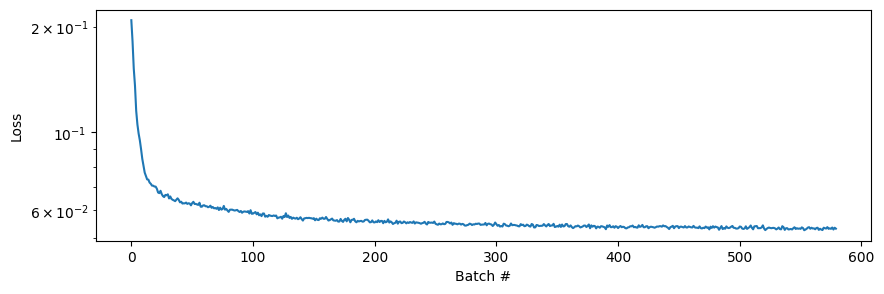

In [8]:
# Plot training log (loss over time)

log = json.load(open(log_file,'r'))
fig,ax = plot_training_log(log=log,loss_type='position_loss')
fig.savefig(os.path.join(data_dir,'training_log.png'),dpi=300)

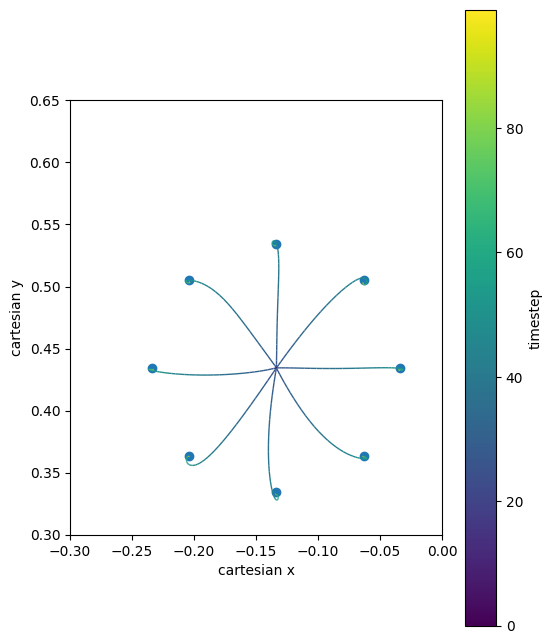

In [9]:
# Plot hand trajectories

xy, tg, all_hidden, all_muscles, vel = test(cfg_file, weight_file, ff_coefficient=0.0)
fig, ax  = plot_simulations(xy=xy, target_xy=tg, vel=None, figsize=(6,8))
fig.savefig(os.path.join(data_dir,'hand_paths.png'),dpi=300)

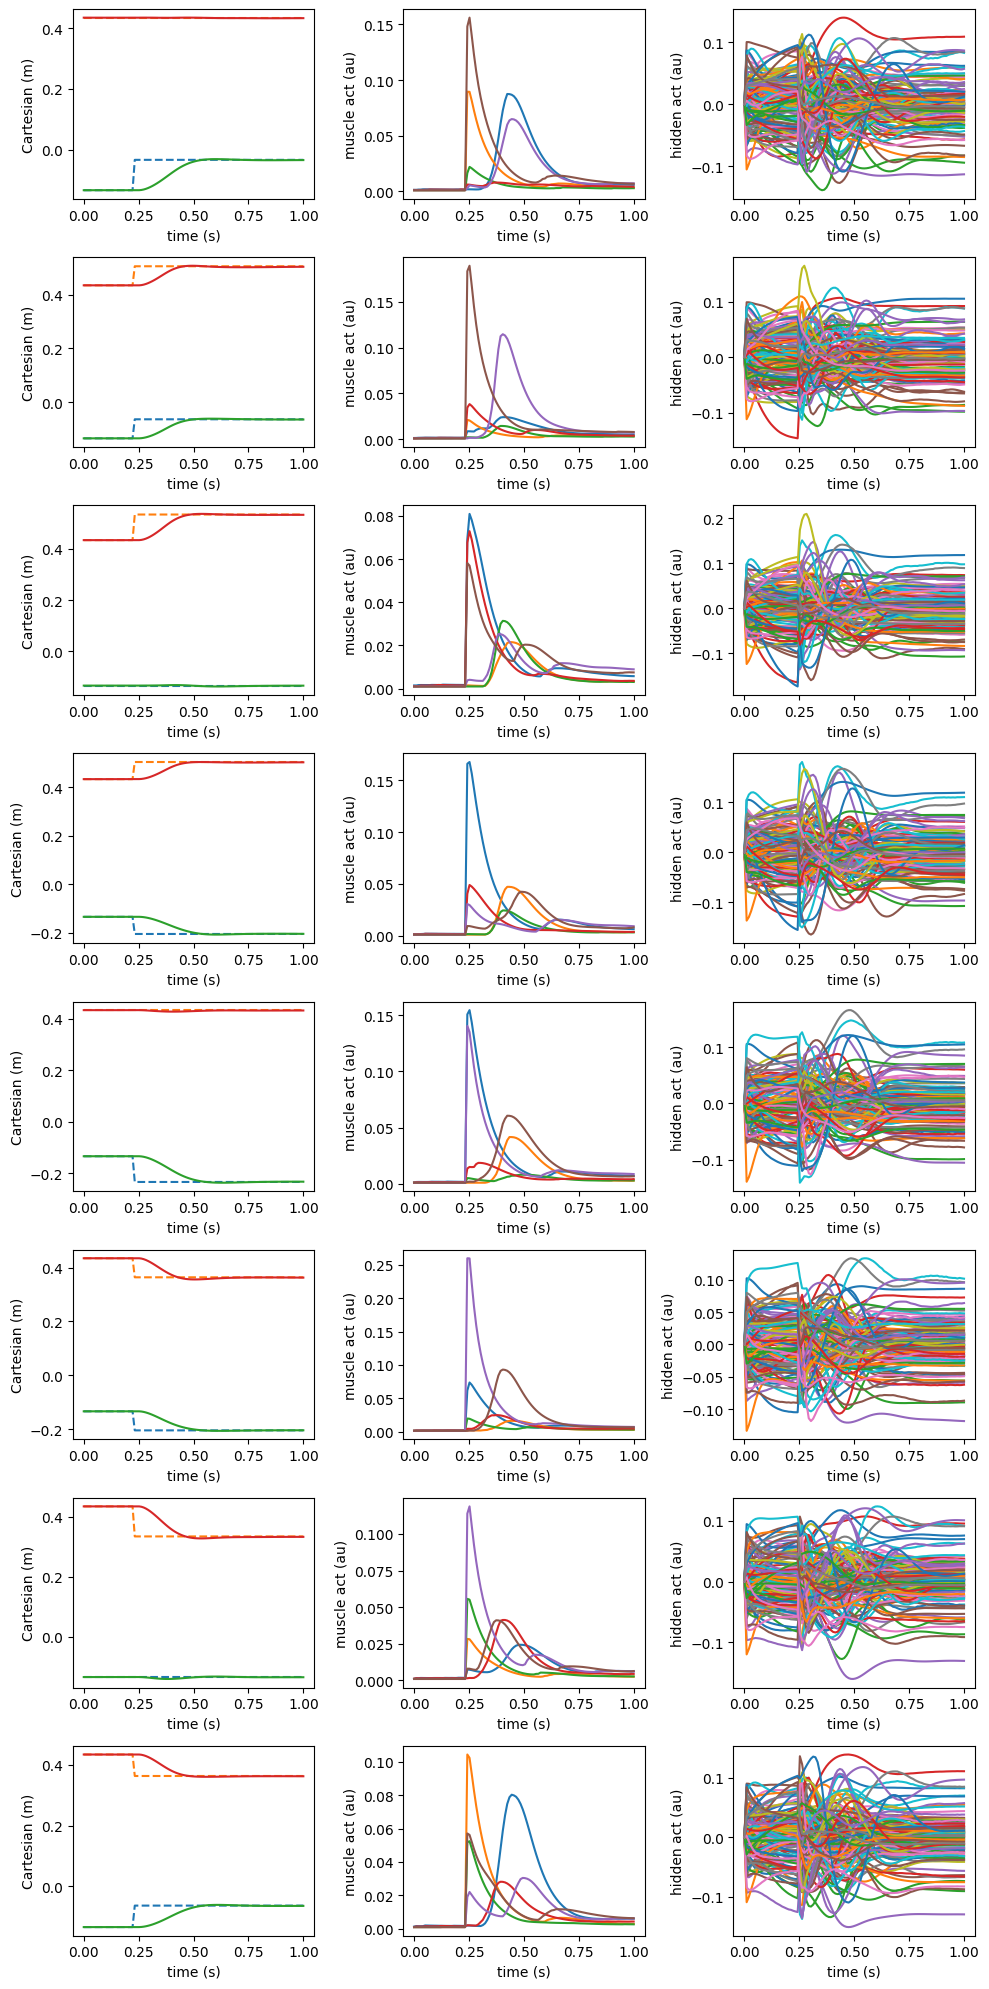

In [10]:
# Plot activations

fig, ax = plot_activation(all_hidden, all_muscles, xy, tg)
fig.savefig(os.path.join(data_dir,'activations.png'),dpi=300)

In [11]:
print(np.shape(log["overall_loss"]))

(29001,)
